Note: *It may take a few seconds for the structures to render, be patient.*

In [1]:
# This notebook shows logo plots and interactive structure widgets.
# It is set up so that it can be parameterized by papermill.
# It is designed so that it can be run in appmode
# (https://github.com/oschuett/appmode), and for that reason has
# comments written mostly in code cells rather than Markdown.

In [2]:
# import Python modules

import io
import os

from IPython.display import display, Image

import matplotlib.image
import matplotlib.pyplot as plt

import nglview

import pandas as pd

import yaml

from dmslogo import facet_plot
from dms_struct.colorschemes import ValueToColorMap
from dms_struct.struct_widget import colored_struct

In [3]:
# This cell is tagged `parameters` to enable papermill parameterization
# See: https://papermill.readthedocs.io/en/latest/usage-parameterize.html

data_csv = 'data/Lee_serum_mapping.csv'  # CSV file with data to plot
serum_group = 'human'  # plot only this `serum_group` in `data_csv`, or `None`
mut_metric = 'mutdiffsel'  # mutation-level selection metric
site_metric = 'positive_diffsel'  # site-level selection metric

outdir = './structure_images/'  # output directory for structure images

pdb = '4o5n'  # PDB ID
# orientation of structure: https://github.com/arose/nglview/issues/785#issuecomment-487409212
orientation = [113.5, 44.09, 180.08, 0, -185.38, 23.99, 110.97, 0,
               2.63, -211.51, 50.12, 0, -34.66, 25.44, 46.9, 1]

# specs for panel of structure images created as image file
panel_height = 3.75  # height of panel plot
panel_top = 0.9  # top margin of panel
panel_wspace = 0.4  # space between subplots
panel_legend_width = 0.3  # width of legend relative to subplots
panel_fig = './structure_images/human_struct_panel.png'  # created panel imaged file

Scale bar mapping the strength of immune selection to the colors in the structure and logo plots:

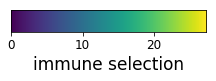

In [4]:
# read the data
data = pd.read_csv(data_csv)

# filter serum group if applicable
if serum_group:
    data = data.query('serum_group == @serum_group')

# get mutation-level data for logo plot plotting
mut_df = (data
          [['serum', 'isite', 'site', 'pdb_chain', 'pdb_site', 'zoom_site',
            'wildtype', 'mutation', mut_metric, site_metric]]
          .assign(site=lambda x: x['site'].astype('str'),
                  site_label=lambda x: x['wildtype'] + x['site'],
                  serum_spaces=lambda x: x['serum'].str.replace('-', ' '))
          )
# get mapper to map site metric to color
colormapper = ValueToColorMap(mut_df[site_metric].min(),
                              mut_df[site_metric].max())

# use the site metric to assign the colors
mut_df = mut_df.assign(color=lambda x: (x[site_metric]
                                        .apply(colormapper.val_to_color)))

# get site level data for structure images
site_df = (mut_df
           [['serum', 'pdb_chain', 'pdb_site', 'zoom_site', 'color']]
           .drop_duplicates()
           )

# show the scale bar
fig, _ = colormapper.scale_bar(label='immune selection',
                               orientation='horizontal')
display(fig)
plt.close(fig)

In [5]:
%%capture
# `%%capture` prevents plots from being shown

# get logo plots for each serum
dy = 0.055 * (colormapper.maxvalue - colormapper.minvalue)  # extra for y-limits
logoplots = {}
for serum, serum_df in mut_df.groupby('serum', sort=False):
    fig, _ = facet_plot(serum_df,
                        gridrow_col='serum_spaces',
                        x_col='isite',
                        show_col='zoom_site',
                        draw_line_kwargs={'height_col': site_metric,
                                          'xtick_col': 'site',
                                          'ylabel': 'immune selection'},
                        draw_logo_kwargs={'letter_col': 'mutation',
                                          'letter_height_col': mut_metric,
                                          'xtick_col': 'site_label',
                                          'color_col': 'color',
                                          'xlabel': 'site',
                                          'ylabel': 'immune selection',
                                          'clip_negative_heights': True},
                        line_titlesuffix='site-level selection',
                        logo_titlesuffix='mutation-level selection',
                        share_ylim_across_rows=False,
                        share_xlabel=True,
                        share_ylabel=True,
                        height_per_ax=2,
                        set_ylims=(-dy, colormapper.maxvalue + dy)
                        )
    logoplots[serum] = fig

In [6]:
# get structure widgets for each serum
widgets = {}
for serum, serum_df in site_df.groupby('serum', sort=False):
    w = colored_struct(pdb=pdb,
                       prop_df=serum_df,
                       chain_col='pdb_chain',
                       site_col='pdb_site',
                       highlight_col='zoom_site',
                       orientation=orientation,
                       )
    widgets[serum] = w

Maps of immune selection for each serum:
 - The line plots show the total selection at each site.
 - The logo plots show selection for each mutation at key sites.
 - The structure uses color to show the selection at each site, with the key sites in the logo plots shown with spheres and the rest shown in cartoon representation.

------------------------ 2010 age 21 ------------------------


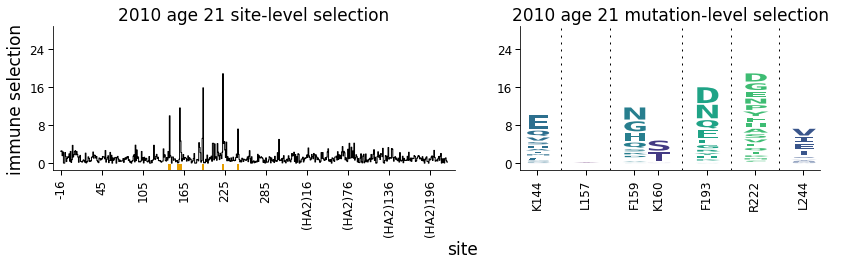

NGLWidget()

------------------------ 2009 age 53 ------------------------


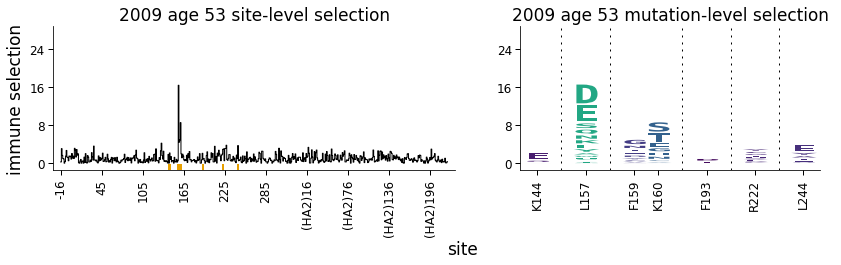

NGLWidget()

------------------------ 2009 age 64 ------------------------


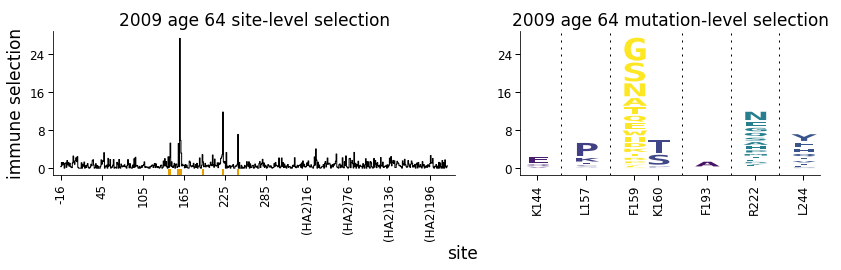

NGLWidget()

------------------------ 2009 age 65 ------------------------


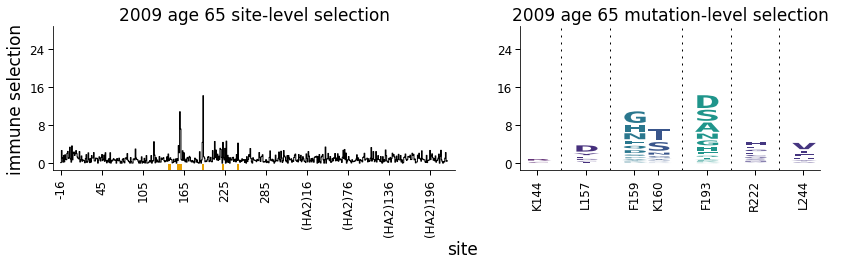

NGLWidget()

In [7]:
# show logo plots and widget for each serum
for serum, logofig in logoplots.items():
    print('-' * 24 + f" {serum.replace('-', ' ')} " + '-' * 24)
    display(logofig)
    display(widgets[serum])

In [8]:
# IMPORTANT: Before running the remaining cells, wait for the
# widgets created by the above cell to complete running!!!!
# Then run each cell below one-by-one with a small pause after each.
# Otherwise, the images you are trying to create may not render.

In [9]:
# save HTML images: https://github.com/arose/nglview/issues/802
os.makedirs(outdir, exist_ok=True)

for serum, w in widgets.items():
    html_file = os.path.join(outdir, f"{serum}.html")
    nglview.write_html(html_file, [w])

In [10]:
# save PNG images: https://github.com/arose/nglview/issues/785#issuecomment-492083727
# Note commands in this cell and next two need to be run in separate cells.
for serum, w in widgets.items():
    w.render_image(antialias=False, factor=4, trim=True)
    w.center()

In [11]:
images = {}
for serum, w in widgets.items():
    images[serum] = w._display_image()

In [12]:
png_files = {}
for serum, image in images.items():
    png_file = os.path.join(outdir, f"{serum}.png")
    with open(png_file, 'wb') as f:
        f.write(image.data)
    png_files[serum] = png_file

In [13]:
# Show all structures in a panel.
# Follow basic idea here to show PNGs as matplotlib plot:
# https://stackoverflow.com/a/50569248

mpimages = {}
for serum, png in png_files.items():
    with open(png, 'rb') as f:
        contents = f.read()
    if contents:
        mpimages[serum] = matplotlib.image.imread(png)
    else:
        dummyfig = plt.figure(figsize=(panel_height, panel_height))
        plt.xticks([], fig=dummyfig)
        plt.yticks([], fig=dummyfig)
        plt.text(0.5, 0.5,
                 f"Empty PNG for {serum}.\n"
                 'Did you allow widgets to render\n'
                 'before running subsequent cells?',
                 va='center', ha='center')
        with io.BytesIO() as f:
            dummyfig.savefig(f, format='png')
            f.seek(0)
            mpimages[serum] = matplotlib.image.imread(f)
        plt.close(dummyfig)

aspects = [img.shape[1] / img.shape[0] for img in mpimages.values()]
aspects.insert(0, sum(aspects) / len(aspects) * panel_legend_width * 0.5)
nax = len(aspects)
figwidth = panel_height * sum(aspects) * (1 + panel_wspace * (nax - 1) / nax)

fig, axes = plt.subplots(
                nrows=1,
                ncols=nax,
                figsize=(figwidth, panel_height),
                gridspec_kw={'width_ratios': aspects},
                )

fig.subplots_adjust(left=0.5 * panel_legend_width / sum(aspects),
                    right=1, bottom=0.02, top=panel_top,
                    wspace=panel_wspace, hspace=0)

_ = colormapper.scale_bar(label='immune selection',
                          orientation='vertical',
                          ax=axes[0])

for ax, (title, img) in zip(axes[1 : ], mpimages.items()):
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title.replace('-', ' '),
                     fontsize=17,
                     verticalalignment='bottom',
                     )

fig.savefig(panel_fig, dpi=400)
        
plt.close(fig)

In [14]:
# to look at the PNG of the panel of images, uncomment the line below
#display(Image(panel_fig))